#                                                                   **Solution For Simulated Claim Data** 

### Gaurav Modi
### gaurav.modi@gmail.com 
### M (908 265 0151)

Main Points 
===========
#### Accuracy = 0.88
#### ROC AUC = 0.86

precision    recall  f1-score   support

           0       0.89      0.97      0.93    113138
           1       0.83      0.53      0.65     28262

    accuracy                           0.88    141400
   macro avg       0.86      0.75      0.79    141400
weighted avg       0.88      0.88      0.87    141400

Profile Report is available in same folder as HTML file. 

Future work
===========
Simple Imputer used because of time constrain, we can improve performance and data quality by using advance imputation algorithms. 
Try different categorical encoding algorithm to acheive better performance and accuracy,
more hyperparameter tuning,
ensambles Models, bagging boosting and stacking 

In [1]:
!pip install -q klib
!pip install -q pandas-profiling
!pip install -q --pre pycaret
!pip install -q category_encoders
!pip install -q catboost
!pip install -q pandas-profiling
!pip install -q shap

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [2]:
import numpy as np 
import pandas as pd 
import category_encoders as ce
#pd.set_option('max_columns', None)
from pandas_profiling import ProfileReport

from sklearn.impute import SimpleImputer
import klib
import shap

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score
from pandas.api.types import is_numeric_dtype
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool

In [3]:
data = pd.read_csv("/kaggle/input/claimdata1/claimData.csv", index_col=None, dtype={'place_of_service_code': 'category', 'is_denial': 'category'})
data = data.drop(['Unnamed: 0','firm_id','service_year','cpt_code_description','state','payer_name','is_approved','using_rcm','diagnosis_code_4','modifier_count','modifier_code_1','modifier_code_2','modifier_code_3','modifier_code_4'], axis=1)
data = data.rename(columns = {'primary_insurance_policy_type':'pipt','primary_insurance_policy_relationship':'pipr','place_of_service_code':'psc'})

## Data Profile (EDA)

In [5]:
import klib
cdata = klib.data_cleaning(data)

cdata.reset_index(drop=True, inplace=True)
from pandas_profiling import ProfileReport
prof = ProfileReport(cdata)
#prof.to_widgets()
prof.to_notebook_iframe()
prof.to_file(output_file='ClaimDataProfile.html')

Shape of cleaned data: (999967, 16)Remaining NAs: 1499911

Changes:
Dropped rows: 10033
     of which 10033 duplicates. (Rows: [257573, 339604, 343282, 361243, 376695, 414927, 438744, 441158, 461223, 464831, 485762, 487705, 505225, 528071, 537441, 560014, 580425, 606480, 621791, 637002, 665220, 666300, 686565, 700790, 716227, 752764, 754250, 760210, 782622, 789116, 796582, 894425, 916153, 980241, 990100, 1000000, 1000001, 1000002, 1000003, 1000004, 1000005, 1000006, 1000007, 1000008, 1000009, 1000010, 1000011, 1000012, 1000013, 1000014, 1000015, 1000016, 1000017, 1000018, 1000019, 1000020, 1000021, 1000022, 1000023, 1000024, 1000025, 1000026, 1000027, 1000028, 1000029, 1000030, 1000031, 1000032, 1000033, 1000034, 1000035, 1000036, 1000037, 1000038, 1000039, 1000040, 1000041, 1000042, 1000043, 1000044, 1000045, 1000046, 1000047, 1000048, 1000049, 1000050, 1000051, 1000052, 1000053, 1000054, 1000055, 1000056, 1000057, 1000058, 1000059, 1000060, 1000061, 1000062, 1000063, 1000064, 1000065

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Imputation & Cleaning

In [4]:
data0 = data.query('is_denial == "0" ')
data0.fillna(data0.mean())

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


is_denial   unitCharge    units       age  diagnosis_count  position  \
0               0   133.970000  1.00000  58.49607         3.000000       1.0   
1               0   138.100000  1.18857  67.00000         1.656298       3.0   
2               0   321.909451  1.00000  75.00000         1.000000       1.0   
3               0   103.300000  1.18857  13.00000         2.000000       2.0   
4               0    80.840000  1.18857  36.00000         3.000000       1.0   
...           ...          ...      ...       ...              ...       ...   
1009995         0   105.440000  1.00000  68.00000         2.000000       1.0   
1009996         0    78.130000  1.00000  30.00000         4.000000       1.0   
1009997         0   185.610000  1.00000  47.00000         1.000000       2.0   
1009998         0  1089.810000  1.00000  65.00000         2.000000       1.0   
1009999         0    52.810000  1.00000  60.00000         1.000000       1.0   

        cpt_code     sex itemType diagnosis_code_1 diagnosis_code_2  \
0          99203  FEMALE      CPT          L02.423          I83.025   
1          99203     NaN      CPT            A30.9          UNKNOWN   
2          99203    MALE      CPT           Z15.09          UNKNOWN   
3          17110  FEMALE  UNKNOWN         S80.911A            L68.2   
4          12032  FEMALE      CPT         S80.811A         S00.30XA   
...          ...     ...      ...              ...              ...   
1009995    99203    MALE      CPT           M33.13           M17.12   
1009996    99212    MALE      CPT              NaN          H60.392   
1009997    96372  FEMALE      CPT              NaN          UNKNOWN   
1009998    12032  FEMALE      NaN              NaN           D22.72   
1009999    99202  FEMALE      CPT            M12.9          UNKNOWN   

        diagnosis_code_3 payer_code              pipt   pipr  psc  
0               T81.33XA      22099               POS   SELF   11  
1                UNKNOWN      87726      ACA_EXCHANGE   SELF   11  
2                UNKNOWN      09102  COMMERCIAL_OTHER   SELF  NaN  
3                UNKNOWN      00021               NaN  CHILD   11  
4               S30.95XA      62308  COMMERCIAL_OTHER   SELF   11  
...                  ...        ...               ...    ...  ...  
1009995          UNKNOWN      87726  GOVERNMENT_OTHER   SELF   11  
1009996         S60.460A      07102          MEDICARE   SELF   11  
1009997          UNKNOWN      57028               IPA  CHILD   11  
1009998          UNKNOWN      00103               NaN   SELF   11  
1009999          UNKNOWN      22099               NaN    NaN   11  

[808024 rows x 16 columns]

In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan,strategy ='most_frequent')
imputer = imputer.fit(data0)
data_with_imputed_values0  = pd.DataFrame(imputer.transform(data0))
data_with_imputed_values0.columns = data.columns
#data_with_imputed_values0.head()

In [6]:
data1 = data.query('is_denial == "1" ')
data1.fillna(data1.mean())

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan,strategy ='most_frequent')
imputer = imputer.fit(data1)
data_with_imputed_values1  = pd.DataFrame(imputer.transform(data1)).copy()
data_with_imputed_values1.columns = data.columns
#data_with_imputed_values1.head()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [7]:
data_clean = pd.concat([data_with_imputed_values0, data_with_imputed_values1], ignore_index=True)
data_clean[['unitCharge', 'units','age','diagnosis_count','position']] = data_clean[['unitCharge', 'units','age','diagnosis_count','position']].round(0).astype(int)
data_clean.shape

(1010000, 16)

In [8]:
import klib
#kdf = klib.data_cleaning(data_clean)
kdf = klib.convert_datatypes(data_clean)
kdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010000 entries, 0 to 1009999
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   is_denial         1010000 non-null  category
 1   unitCharge        1010000 non-null  int32   
 2   units             1010000 non-null  int8    
 3   age               1010000 non-null  int8    
 4   diagnosis_count   1010000 non-null  int8    
 5   position          1010000 non-null  int8    
 6   cpt_code          1010000 non-null  category
 7   sex               1010000 non-null  category
 8   itemType          1010000 non-null  category
 9   diagnosis_code_1  1010000 non-null  category
 10  diagnosis_code_2  1010000 non-null  category
 11  diagnosis_code_3  1010000 non-null  category
 12  payer_code        1010000 non-null  category
 13  pipt              1010000 non-null  category
 14  pipr              1010000 non-null  category
 15  psc               1010000 non-nu

In [18]:
kdf.reset_index(drop=True, inplace=True)
kdf.head()

is_denial  unitCharge  units  age  diagnosis_count  position cpt_code  \
0         0         133      1   58                3         1    99203   
1         0         138      1   67                2         3    99203   
2         0         322      1   75                1         1    99203   
3         0         103      1   13                2         2    17110   
4         0          80      1   36                3         1    12032   

      sex itemType diagnosis_code_1 diagnosis_code_2 diagnosis_code_3  \
0  FEMALE      CPT          L02.423          I83.025         T81.33XA   
1  FEMALE      CPT            A30.9          UNKNOWN          UNKNOWN   
2    MALE      CPT           Z15.09          UNKNOWN          UNKNOWN   
3  FEMALE  UNKNOWN         S80.911A            L68.2          UNKNOWN   
4  FEMALE      CPT         S80.811A         S00.30XA         S30.95XA   

  payer_code              pipt   pipr psc  
0      22099               POS   SELF  11  
1      87726      ACA_EXCHANGE   SELF  11  
2      09102  COMMERCIAL_OTHER   SELF  11  
3      00021          MEDICARE  CHILD  11  
4      62308  COMMERCIAL_OTHER   SELF  11

In [13]:
data_clean.shape

(999429, 16)

In [12]:
data_clean = data_clean.drop_duplicates()

## Preparing Data For Model


In [14]:
#mdf, data_test = train_test_split(data_clean, stratify=data["is_denial"], test_size=0.20)
mdf, data_test = train_test_split(kdf, stratify=data["is_denial"], test_size=0.20)

In [15]:
X = mdf[['unitCharge', 'units', 'age', 'diagnosis_count',
       'position', 'cpt_code', 'sex',
       'itemType', 'diagnosis_code_1',
       'diagnosis_code_2', 'diagnosis_code_3',
       'payer_code', 'pipt', 'pipr', 'psc']]
y = mdf['is_denial']

In [16]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

categorical_indicies = get_categorical_indicies(X)

In [17]:
def convert_cats(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
    else:
        cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')
convert_cats(X)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

train_dataset = cb.Pool(X_train,y_train, cat_features=categorical_indicies)
test_dataset = cb.Pool(X_test,y_test, cat_features=categorical_indicies)

model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', verbose = False)

grid = {'learning_rate': [0.03, 0.1],'depth': [4, 6, 10],'l2_leaf_reg': [1, 3, 5,],'iterations': [50, 100, 150]}

model.grid_search(grid,train_dataset,verbose = False)


bestTest = 0.8465655941
bestIteration = 49


bestTest = 0.8522277228
bestIteration = 46


bestTest = 0.8468131188
bestIteration = 49


bestTest = 0.8518796411
bestIteration = 47


bestTest = 0.8469214109
bestIteration = 49


bestTest = 0.8518022896
bestIteration = 48


bestTest = 0.8502784653
bestIteration = 97


bestTest = 0.8545405322
bestIteration = 98


bestTest = 0.850417698
bestIteration = 99


bestTest = 0.8539371906
bestIteration = 99


bestTest = 0.8502862005
bestIteration = 99


bestTest = 0.8536819307
bestIteration = 99


bestTest = 0.8515857054
bestIteration = 149


bestTest = 0.8549659653
bestIteration = 149


bestTest = 0.8516630569
bestIteration = 148


bestTest = 0.8551825495
bestIteration = 149


bestTest = 0.8516630569
bestIteration = 149


bestTest = 0.8553836634
bestIteration = 147


bestTest = 0.8491181931
bestIteration = 49


bestTest = 0.8538288985
bestIteration = 49


bestTest = 0.8495049505
bestIteration = 49


bestTest = 0.8537206064
bestIteration = 49


best

{'params': {'depth': 10,
  'l2_leaf_reg': 1,
  'iterations': 150,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [19]:
model.get_feature_importance()

array([ 5.62397897,  0.55036113,  2.69777128,  1.36903079,  4.70238528,
       16.75843634,  0.87260414,  3.86949342, 29.90850888,  0.42080282,
        0.        , 28.23408772,  1.44584855,  2.50789511,  1.03879556])

## Performance of the Model

In [20]:
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.92    129280
           1       0.78      0.39      0.52     32320

    accuracy                           0.86    161600
   macro avg       0.82      0.68      0.72    161600
weighted avg       0.85      0.86      0.84    161600



In [21]:
val_data = (X_test, y_test)

def validate(model, val_data):
    y = model.predict(val_data[0])
    print('Accuracy =', accuracy_score(y, val_data[1]))
    print('ROC AUC =', roc_auc_score(y, val_data[1]))
    #print('F1 =', f1_score(y, val_data[1]))

validate(model, val_data)

Accuracy = 0.8560272277227723
ROC AUC = 0.8242322786930235


In [22]:
## saving Model on Disk
model.save_model("model")
from_file = CatBoostClassifier()
from_file.load_model("model")

In [29]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

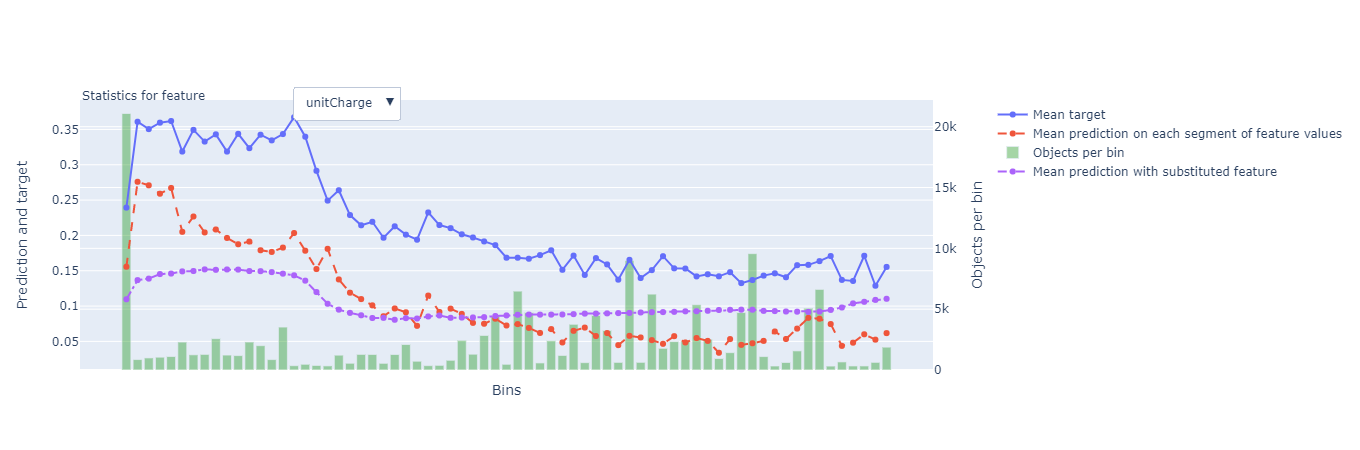

{'borders': array([5.000e-01, 1.500e+00, 2.500e+00, 3.500e+00, 4.500e+00, 6.500e+00,
        7.500e+00, 8.500e+00, 1.050e+01, 1.150e+01, 1.250e+01, 1.450e+01,
        1.650e+01, 1.750e+01, 2.350e+01, 2.450e+01, 2.650e+01, 2.850e+01,
        3.050e+01, 3.850e+01, 4.150e+01, 4.750e+01, 5.250e+01, 5.450e+01,
        5.850e+01, 6.450e+01, 6.650e+01, 6.750e+01, 6.850e+01, 7.050e+01,
        7.650e+01, 7.950e+01, 8.550e+01, 9.450e+01, 9.550e+01, 1.075e+02,
        1.155e+02, 1.165e+02, 1.205e+02, 1.225e+02, 1.285e+02, 1.295e+02,
        1.365e+02, 1.415e+02, 1.425e+02, 1.565e+02, 1.575e+02, 1.675e+02,
        1.705e+02, 1.745e+02, 1.785e+02, 1.885e+02, 1.935e+02, 1.955e+02,
        1.985e+02, 2.095e+02, 2.425e+02, 2.485e+02, 2.505e+02, 2.545e+02,
        2.675e+02, 3.365e+02, 4.875e+02, 4.975e+02, 5.215e+02, 5.365e+02,
        5.525e+02, 6.035e+02], dtype=float32),
 'binarized_feature': array([41, 40, 45, ..., 14, 27, 61]),
 'mean_target': array([0.23933975, 0.36088476, 0.35045317, 0.3595825

In [25]:
model.calc_feature_statistics(test_dataset,feature='unitCharge',plot=True,prediction_type='Class')

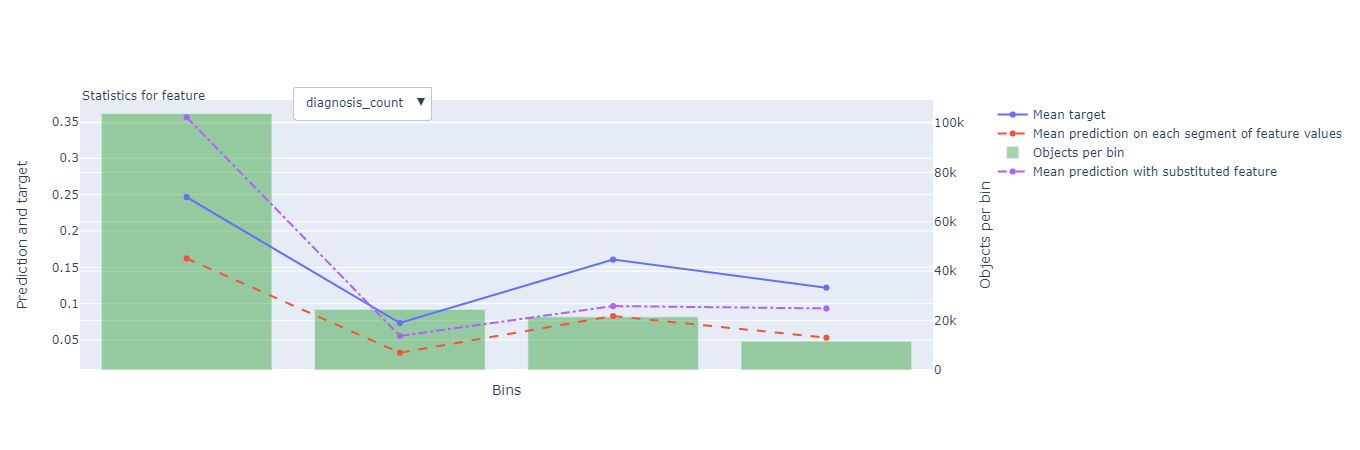

{'borders': array([1.5, 2.5, 3.5], dtype=float32),
 'binarized_feature': array([0, 0, 0, ..., 0, 1, 1]),
 'mean_target': array([0.24660793, 0.0733575 , 0.16058157, 0.12204522], dtype=float32),
 'mean_weighted_target': array([], dtype=float32),
 'mean_prediction': array([0.16228032, 0.03246304, 0.08300818, 0.05318602], dtype=float32),
 'objects_per_bin': array([103845,  24551,  21528,  11676], dtype=uint32),
 'predictions_on_varying_feature': array([0.35645421, 0.05555693, 0.09669554, 0.09340347])}

In [24]:
model.calc_feature_statistics(test_dataset,feature='diagnosis_count',plot=True,prediction_type='Class')

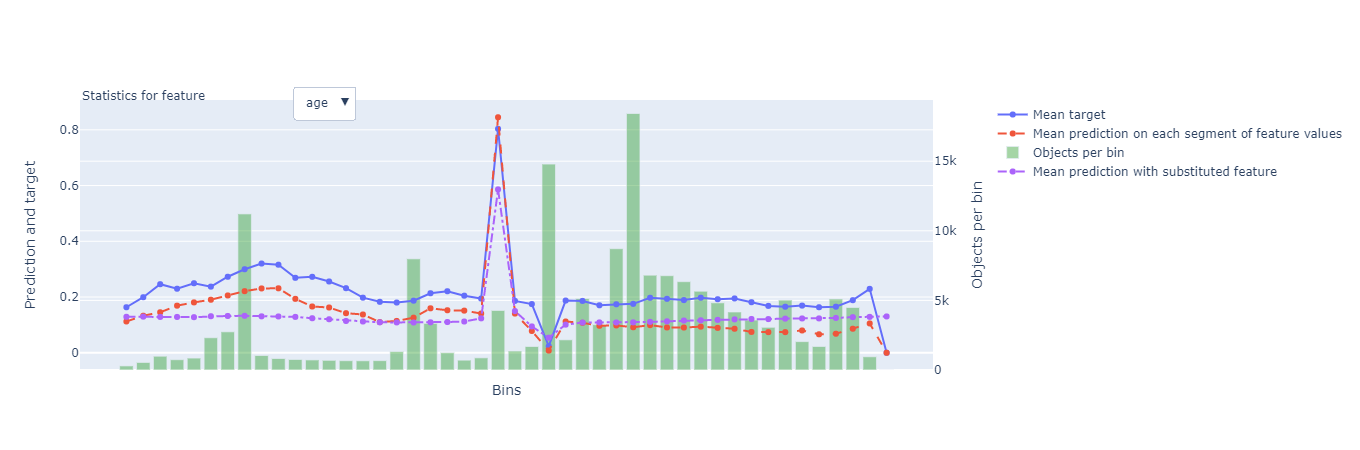

{'borders': array([  5.5,   7.5,   9.5,  10.5,  11.5,  13.5,  15.5,  23.5,  24.5,
         25.5,  26.5,  27.5,  28.5,  29.5,  30.5,  31.5,  33.5,  45.5,
         50.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
         61.5,  62.5,  64.5,  67.5,  68.5,  69.5,  70.5,  71.5,  72.5,
         73.5,  74.5,  75.5,  77.5,  78.5,  79.5,  84.5,  92.5, 101.5],
       dtype=float32),
 'binarized_feature': array([20, 38, 33, ..., 33, 30, 22]),
 'mean_target': array([0.1632653 , 0.199262  , 0.24596775, 0.22972973, 0.24941725,
        0.23727351, 0.27269414, 0.29967892, 0.3201923 , 0.31598064,
        0.26887417, 0.2724758 , 0.25574714, 0.2316891 , 0.19758673,
        0.18276374, 0.18018018, 0.18685034, 0.21349657, 0.22070625,
        0.20480226, 0.19450802, 0.8034128 , 0.18608059, 0.17465957,
        0.02345704, 0.18735579, 0.18597858, 0.17030433, 0.17387812,
        0.17541385, 0.19729888, 0.19350554, 0.18893792, 0.1975265 ,
        0.19208454, 0.1948644 , 0.18138757, 0.16813295, 0.1

In [25]:
model.calc_feature_statistics(test_dataset,feature='age',plot=True,prediction_type='Class')

In [27]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

#### The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

#### If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive)

In [28]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[0:100,:], X.iloc[0:100,:])

#### To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high Diagnosis Counts less chances your claim will be deny.   

#### same analysis we can do for all variables age, unitCharge, position, units and modifier_count_2


#### other categorical variables with high counts such as diagnosis_codes, payer_codes are encoded by catboost so hard to explain. 

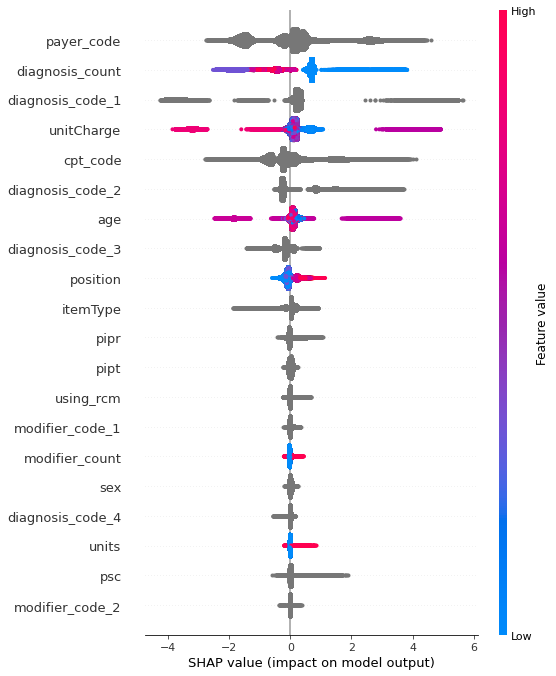

In [29]:
shap.summary_plot(shap_values, X)

#### This plot is made of many dots. Each dot has three characteristics:

#### Vertical location shows what feature it is depicting
#### Color shows whether that feature was high or low for that row of the dataset
#### Horizontal location shows whether the effect of that value caused a higher or lower prediction.

# Converting Model To REST API (FastAPI)

In [ ]:
# 1. Library imports
import pandas as pd
from pycaret.regression import load_model, predict_model
from fastapi import FastAPI
import uvicorn

# 2. Create the app object
app = FastAPI()

#. Load trained Pipeline
model = load_model('Final_catboost_Model_04Feb2023')

# Define predict function
@app.post('/predict')
def predict(unitCharge,units,age,diagnosis_count,modifier_count,position,using_rcm,cpt_code,sex,itemType,modifier_code_1,modifier_code_2,modifier_code_3,modifier_code_4,diagnosis_code_1,diagnosis_code_2,diagnosis_code_3,diagnosis_code_4,payer_code,pipt,pipr,psc):
    data = pd.DataFrame([[unitCharge,units,age,diagnosis_count,modifier_count,position,using_rcm,cpt_code,sex,itemType,modifier_code_1,modifier_code_2,modifier_code_3,modifier_code_4,diagnosis_code_1,diagnosis_code_2,diagnosis_code_3,diagnosis_code_4,payer_code,pipt,pipr,psc]])
    data.columns = ['unitCharge','units','age','diagnosis_count','modifier_count','position','using_rcm','cpt_code','sex','itemType','modifier_code_1','modifier_code_2','modifier_code_3','modifier_code_4','diagnosis_code_1','diagnosis_code_2','diagnosis_code_3','diagnosis_code_4','payer_code','pipt','pipr','psc']

    predictions = predict_model(model, data=data) 
    return {'prediction': int(predictions['Label'][0])}

if __name__ == '__main__':
    uvicorn.run(app, host='127.0.0.1', port=8000)

# Deploy Model as Rest API on AWS Lambda (ServerLess Architecture)

In [ ]:
# Execution Role : FastApiLambdaRole
# RunTime : Python 3.8
# Layer1 (ARN) : arn:aws:lambda:us-west-2:446751924810:layer:python-3-8-scikit-learn-0-23-1:4
# Layer2 (Custom) : pythonpackage(FastAPI libs)

import json
import joblib
import re
import string
from bs4 import BeautifulSoup
import numpy as np

from fastapi import FastAPI
from pydantic import BaseModel
from mangum import Mangum
import tempfile
import boto3

s3_client = boto3.client("s3")


# Declaring our FastAPI instance
app = FastAPI()
lambda_handler = Mangum(app)

# Defining path operation for root endpoint
@app.get("/")
def main():
    return {"message": "Welcome to AI!"}

class request_body(BaseModel):
        unitCharge: string
        units: string
        age: string
        diagnosis_count: string
        modifier_count: string
        position: string: stringusing_rcm: string
        cpt_code: string
        sex: string
        itemType: string
        modifier_code_1: string
        modifier_code_2: string
        modifier_code_3: string
        modifier_code_4: string
        diagnosis_code_1: string
        diagnosis_code_2: string
        diagnosis_code_3: string
        diagnosis_code_4: string
        payer_code: string
        pipt: string
        pipr: string
        psc: string

@app.post("/SimulatedClaimData")
def ClaimData(data: request_body):
    
        # READ Model From S3
        with tempfile.TemporaryFile() as fp:
            s3_client.download_fileobj(
                Fileobj=fp,
                Bucket="###-ai-s3-dev",
                Key="./Final catboost Model 04Feb2023.pkl",
            )
            fp.seek(0)
            model = joblib.load(fp)
            prediction = predict_model(model, data=data_unseen)
            prediction.[0]
return {prediction.[0]}



#### Other Models 

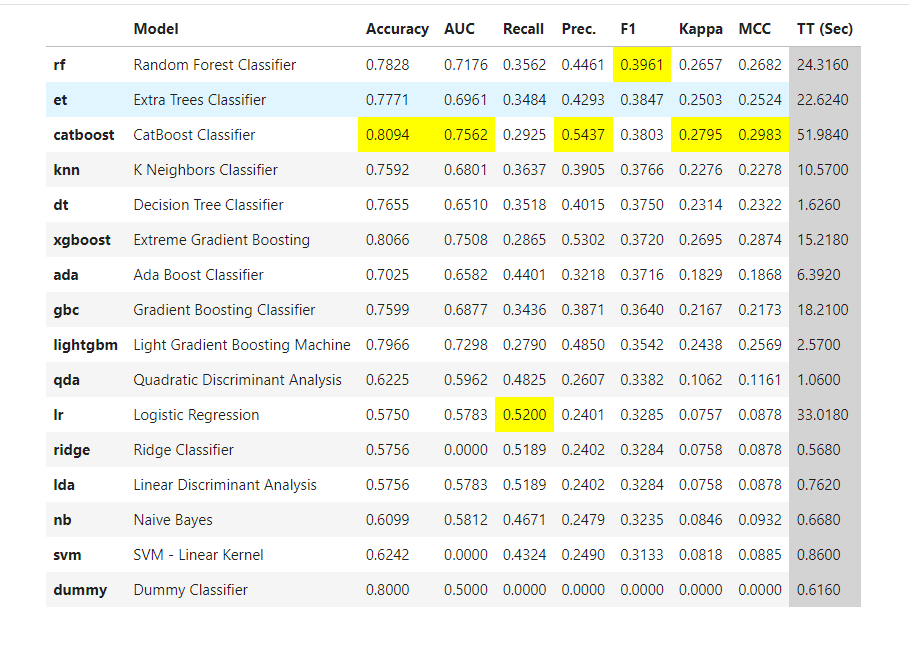